# Link iNaturalist observations to TRY

Link iNaturalist vascular plant observations to the previously created trait TRY summary statistics.

This section covers:

- Load data
- Link iNat and TRY
- Fuzzy merge
- Log trait values
- Number of observations per trait
- Plot observation density after linking

## Packages

In [ ]:
import pandas as pd
import os
import numpy as np

# fuzzy matching
#import rapidfuzz
from rapidfuzz import process, fuzz

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import cartopy.crs as ccrs # plot maps
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Load data

We load the iNaturalist vascular plant observations and the TRY summary stats per species.

In [2]:
iNat = pd.read_csv("Data/iNat/observations.csv")
iNat.head(3)


,gbifID,scientificName,decimalLatitude,decimalLongitude,eventDate,dateIdentified
0,1229615436,Commelina communis,35.987483,-79.057546,2013-07-07T00:00:00,2013-07-07T20:33:11
1,1802610589,Blitum capitatum,40.320259,-105.604856,2013-08-24T13:30:00,2019-09-02T01:11:54
2,1212005116,Passiflora vitifolia,23.189257,-106.404924,2014-03-18T12:49:37,2017-02-23T17:24:07


Load trait measurments with consolidated species name:

In [3]:
TRY = pd.read_csv("Data/TRY/TRY_summary_stats.csv")
TRY.head(2)

,AccSpeciesName,Dispersal unit length,Leaf Area,SLA,Leaf C,LDMC,Leaf fresh mass,Leaf N per area,Leaf N per mass,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,Aa,NaN,NaN,9.433962,NaN,NaN,NaN,2.7984,26.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaronsohnia pubescens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
TRY.shape

(51908, 19)

In [5]:
iNat.shape

(14019405, 6)

In [6]:
# check that we have only unique observation ID's
iNat["gbifID"].nunique()

14019405

## Link iNaturalist and TRY

Non-fuzzy merge with TRY summary stats on **consolidated TRY species name**:


In [7]:
iNat_TRY = pd.merge(iNat, TRY, 
                    left_on= ['scientificName'],
                    right_on= ['AccSpeciesName'], 
                    how='inner')
iNat_TRY.head(3)

,gbifID,scientificName,decimalLatitude,decimalLongitude,eventDate,dateIdentified,AccSpeciesName,Dispersal unit length,Leaf Area,SLA,...,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,1229615436,Commelina communis,35.987483,-79.057546,2013-07-07T00:00:00,2013-07-07T20:33:11,Commelina communis,NaN,NaN,NaN,...,NaN,12.631579,1.71,NaN,8.48,NaN,NaN,NaN,NaN,NaN
1,3384000233,Commelina communis,42.093762,-75.923660,2021-08-23T13:06:06,2021-09-17T21:15:37,Commelina communis,NaN,NaN,NaN,...,NaN,12.631579,1.71,NaN,8.48,NaN,NaN,NaN,NaN,NaN
2,1807276585,Commelina communis,40.787636,-73.933728,2017-09-04T12:47:58,2017-09-04T21:58:57,Commelina communis,NaN,NaN,NaN,...,NaN,12.631579,1.71,NaN,8.48,NaN,NaN,NaN,NaN,NaN


We repeat the same with the **'original' species name** in TRY:

In [8]:
TRY_syn = pd.read_csv("Data/TRY/TRY_summary_stats_syn.csv")
TRY_syn.head(2)

,SpeciesName,Dispersal unit length,Leaf Area,SLA,Leaf C,LDMC,Leaf fresh mass,Leaf N per area,Leaf N per mass,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,(fabaceae),NaN,NaN,21.3385,NaN,NaN,NaN,1.578157,33.150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(fabaceae) 20-25oblong,NaN,NaN,NaN,NaN,NaN,NaN,1.761453,32.513864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Extract from TRY those observations that have not been matched:

In [9]:
# filter for observations not in merged dataframe:
iNat_rest = iNat[~iNat.gbifID.isin(iNat_TRY['gbifID'])]
iNat_rest.shape

(2541013, 6)

In [10]:
# non-fuzzy merge with TRY summary stats on original TRY species name:

iNat_TRY_syn = pd.merge(iNat_rest, TRY_syn, 
                    left_on= ['scientificName'],
                    right_on= ['SpeciesName'], 
                    how='inner')
iNat_TRY_syn.head(3)

,gbifID,scientificName,decimalLatitude,decimalLongitude,eventDate,dateIdentified,SpeciesName,Dispersal unit length,Leaf Area,SLA,...,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,1802610589,Blitum capitatum,40.320259,-105.604856,2013-08-24T13:30:00,2019-09-02T01:11:54,Blitum capitatum,NaN,NaN,NaN,...,NaN,NaN,NaN,0.45,NaN,NaN,NaN,NaN,NaN,NaN
1,2283078677,Blitum capitatum,50.744232,-120.511303,2019-06-29T17:50:28,2019-09-02T01:16:41,Blitum capitatum,NaN,NaN,NaN,...,NaN,NaN,NaN,0.45,NaN,NaN,NaN,NaN,NaN,NaN
2,2864818488,Blitum capitatum,53.938056,-106.068553,2020-08-22T12:22:09,2020-08-22T19:13:24,Blitum capitatum,NaN,NaN,NaN,...,NaN,NaN,NaN,0.45,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
subsets = [iNat_TRY, iNat_TRY_syn]

iNat_TRY_all = pd.concat(subsets)

In [12]:
iNat_TRY_all = iNat_TRY_all.drop(['AccSpeciesName', 'SpeciesName'], axis = 1)

In [13]:
iNat_TRY_all.head(3)

,gbifID,scientificName,decimalLatitude,decimalLongitude,eventDate,dateIdentified,Dispersal unit length,Leaf Area,SLA,Leaf C,...,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,1229615436,Commelina communis,35.987483,-79.057546,2013-07-07T00:00:00,2013-07-07T20:33:11,NaN,NaN,NaN,NaN,...,NaN,12.631579,1.71,NaN,8.48,NaN,NaN,NaN,NaN,NaN
1,3384000233,Commelina communis,42.093762,-75.923660,2021-08-23T13:06:06,2021-09-17T21:15:37,NaN,NaN,NaN,NaN,...,NaN,12.631579,1.71,NaN,8.48,NaN,NaN,NaN,NaN,NaN
2,1807276585,Commelina communis,40.787636,-73.933728,2017-09-04T12:47:58,2017-09-04T21:58:57,NaN,NaN,NaN,NaN,...,NaN,12.631579,1.71,NaN,8.48,NaN,NaN,NaN,NaN,NaN


In [14]:
iNat_TRY_all.shape

(11806220, 24)

In [15]:
iNat_TRY_all["gbifID"].nunique()

11806220

In [16]:
# agian filter for observations not in merged dataframe:
iNat_rest_2 = iNat[~iNat.gbifID.isin(iNat_TRY_all['gbifID'])]
iNat_rest_2.shape

(2213185, 6)

Check how much was matched:

In [17]:
print('iNat species:')
print(iNat["scientificName"].nunique())
print('TRY consolidated species:')
print(TRY["AccSpeciesName"].nunique())
print('TRY original species:')
print(TRY_syn["SpeciesName"].nunique())
print('species merged:')
print(iNat_TRY_all["scientificName"].nunique())
print('iNat species not merged:')
print(iNat_rest_2["scientificName"].nunique())

# percentage of iNat observations linked with at least one TRY trait
print('percentage of iNat observations linked with at least one TRY trait:')
print(len(iNat_TRY_all)/len(iNat))

iNat species:
90820
TRY consolidated species:
51908
TRY original species:
61180
species merged:
27783
iNat species not merged:
63037
percentage of iNat observations linked with at least one TRY trait:
0.8421341704587321


## Fuzzy merge

Get only unique species names left in iNaturalist unmatched observations:

In [18]:
iNat_rest_unique = iNat_rest_2.drop_duplicates(subset=['scientificName'])

Get only unique unmatched TRY species names:

In [19]:
pd.options.mode.chained_assignment = None

TRY = pd.read_csv("Data/TRY/TRY_summary_stats.csv")
TRY_alt =  pd.read_csv("Data/TRY/TRY_summary_stats_syn.csv")

TRY_rest = TRY[~TRY.AccSpeciesName.isin(iNat_TRY_all['scientificName'])]
TRY_alt_rest =  TRY_alt[~TRY_alt.SpeciesName.isin(iNat_TRY_all['scientificName'])]

TRY_alt_rest.rename(columns = {'SpeciesName':'AccSpeciesName'}, inplace = True)


TRY_R = pd.concat([TRY_rest, TRY_alt_rest])
TRY_rest_unique = TRY_R.drop_duplicates(subset=['AccSpeciesName'])

TRY_rest_unique.head()

,AccSpeciesName,Dispersal unit length,Leaf Area,SLA,Leaf C,LDMC,Leaf fresh mass,Leaf N per area,Leaf N per mass,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,Aa,NaN,NaN,9.433962,NaN,NaN,NaN,2.7984,26.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abacaba (palm),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Abarema adenophorum,NaN,3038.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.360000,NaN
5,Abarema alexandri,NaN,675.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Abarema barbouriana,NaN,29.811258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.496843,0.456346,NaN


In [20]:
# define choices and queries
# this might take a little while

choices = TRY_rest_unique["AccSpeciesName"].apply(str)
queries = iNat_rest_unique["scientificName"]


score_sort = [(x,) + i
             for x in queries
             for i in process.extract(x, choices, score_cutoff=90, scorer=fuzz.token_sort_ratio) ]

fuzzy_matches = pd.DataFrame(score_sort)
fuzzy_matches.head()

,0,1,2,3
0,Sambucus cerulea,Sambucus caerulea,96.969697,42779
1,Anemonoides sylvestris,Anemone sylvestris,90.000000,3146
2,Elymus hystrix,Elymus histrix,92.857143,20225
3,Euphorbia enterophora,Euphorbia eriophora,90.000000,19508
4,Tanacetum partheniifolium,Tanacetum parthenifolium,97.959184,47633


Save fuzzy match to ```.csv```:

In [21]:
fuzzy_matches.to_csv("Data/fuzzy_matches.csv", sep = "\t",index=False)

Reload fuzzy matches:

In [22]:
fuzzy_matches =  pd.read_csv("Data/fuzzy_matches.csv", sep = "\t")
fuzzy_matches.head()

,0,1,2,3
0,Sambucus cerulea,Sambucus caerulea,96.969697,42779
1,Anemonoides sylvestris,Anemone sylvestris,90.000000,3146
2,Elymus hystrix,Elymus histrix,92.857143,20225
3,Euphorbia enterophora,Euphorbia eriophora,90.000000,19508
4,Tanacetum partheniifolium,Tanacetum parthenifolium,97.959184,47633


Add new names to unmatched iNaturalist observations: ```iNat_rest_2``` with ```fuzzy_matches```


In [23]:
fuzzy_matches.rename(columns = {'0':'scientificName'}, inplace = True)
fuzzy_matches.rename(columns = {'1':'fuzzyName'}, inplace = True)
iNat_rest_fuzzy = pd.merge(iNat_rest_2, fuzzy_matches, on='scientificName', how='inner')

Merge with TRY:

In [24]:
TRY = pd.read_csv("Data/TRY/TRY_summary_stats.csv")
TRY_alt =  pd.read_csv("Data/TRY/TRY_summary_stats_syn.csv")

TRY.rename(columns = {'AccSpeciesName':'fuzzyName'}, inplace = True)
iNat_TRY_fuzzy_1 = pd.merge(iNat_rest_fuzzy, TRY, on='fuzzyName', how='inner')
iNat_TRY_fuzzy_rest = iNat_rest_fuzzy[~iNat_rest_fuzzy.gbifID.isin(iNat_TRY_fuzzy_1['gbifID'])]
iNat_TRY_fuzzy_1= iNat_TRY_fuzzy_1.drop(columns=["fuzzyName", "2", "3"])

TRY_alt.rename(columns = {'SpeciesName':'fuzzyName'}, inplace = True)
iNat_TRY_fuzzy_2 = pd.merge(iNat_TRY_fuzzy_rest, TRY_alt, on='fuzzyName', how='inner')
iNat_TRY_fuzzy_2= iNat_TRY_fuzzy_2.drop(columns=["fuzzyName", "2", "3"])

In [25]:
# merge fuzzy-consolidated species name match and fuzzy-original match
frames = [iNat_TRY_fuzzy_1, iNat_TRY_fuzzy_2]

iNat_TRY_fuzzy_merge = pd.concat(frames)

In [26]:
iNat_TRY_fuzzy_merge['gbifID'].nunique()/len(iNat_TRY_fuzzy_merge['gbifID'])

0.9933762301286904

Drop iNat observation duplicates in fuzzy matches, keeping the row with the least NaN

In [27]:
iNat_TRY_fuzzy_merge_2 = (iNat_TRY_fuzzy_merge.assign(counts=iNat_TRY_fuzzy_merge.count(axis=1))
   .sort_values(['gbifID', 'counts'])
   .drop_duplicates('gbifID', keep='last')
   .drop('counts', axis=1))

In [28]:
iNat_TRY_fuzzy_merge.shape

(89828, 24)

In [29]:
iNat_TRY_fuzzy_merge_2.shape

(89233, 24)

Concatenate to make final dataframe:

In [30]:
frames = [iNat_TRY_all, iNat_TRY_fuzzy_merge_2]

iNat_TRY_final = pd.concat(frames)

Compare shape to number of unique gbif ID's, check that they are the same. We want each observation represented only once:

In [31]:
iNat_TRY_final.shape

(11895453, 24)

In [32]:
iNat_TRY_final['gbifID'].nunique()

11895453

In [33]:
iNat_TRY_final.head()

,gbifID,scientificName,decimalLatitude,decimalLongitude,eventDate,dateIdentified,Dispersal unit length,Leaf Area,SLA,Leaf C,...,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,1229615436,Commelina communis,35.987483,-79.057546,2013-07-07T00:00:00,2013-07-07T20:33:11,NaN,NaN,NaN,NaN,...,NaN,12.631579,1.71,NaN,8.48,NaN,NaN,NaN,NaN,NaN
1,3384000233,Commelina communis,42.093762,-75.923660,2021-08-23T13:06:06,2021-09-17T21:15:37,NaN,NaN,NaN,NaN,...,NaN,12.631579,1.71,NaN,8.48,NaN,NaN,NaN,NaN,NaN
2,1807276585,Commelina communis,40.787636,-73.933728,2017-09-04T12:47:58,2017-09-04T21:58:57,NaN,NaN,NaN,NaN,...,NaN,12.631579,1.71,NaN,8.48,NaN,NaN,NaN,NaN,NaN
3,3355124418,Commelina communis,39.643158,-76.764245,2020-08-26T10:19:56,2020-08-27T13:21:22,NaN,NaN,NaN,NaN,...,NaN,12.631579,1.71,NaN,8.48,NaN,NaN,NaN,NaN,NaN
4,1802638502,Commelina communis,43.109505,1.622543,2017-10-21T10:01:00,2017-10-21T09:02:42,NaN,NaN,NaN,NaN,...,NaN,12.631579,1.71,NaN,8.48,NaN,NaN,NaN,NaN,NaN


After matching with alternate name and a conservative fuzzy match, we were able to match about 85% of the iNaturalist observations with trait information. Many rare species seem to be absent in either one of the two databases.


In [34]:
print('percentage of iNat observations linked with at least one TRY trait:')
print(len(iNat_TRY_final)/len(iNat))

print('percentage of species in iNaturalist matched with TRY:')
print(iNat_TRY_final["scientificName"].nunique()/iNat["scientificName"].nunique())

print('percentage of species in TRY matched with iNaturalist:')
print(iNat_TRY_final["scientificName"].nunique()/TRY["fuzzyName"].nunique())

percentage of iNat observations linked with at least one TRY trait:
0.8484991338790769
percentage of species in iNaturalist matched with TRY:
0.3161528297731777
percentage of species in TRY matched with iNaturalist:
0.5531517299838176


In [35]:
iNat_TRY_final.to_csv("Data/iNat_TRY.csv", index=False)

## Log trait values

The cwm in sPlot were caluclated after being log e transformed, so we must log e transform iNat data also:

In [36]:
trait = iNat_TRY_final.columns[6:24]
iNat_TRY_final.loc[:, trait] = np.log(iNat_TRY_final[trait])

In [37]:
iNat_TRY_final = iNat_TRY_final.replace(-np.inf, np.nan)
iNat_TRY_final = iNat_TRY_final.replace(np.inf, np.nan)

In [38]:
iNat_TRY_final.to_csv("Data/iNat_TRY_log.csv", index=False)

## Number of observations per trait

In [39]:
iNat_TRY_final.head()

,gbifID,scientificName,decimalLatitude,decimalLongitude,eventDate,dateIdentified,Dispersal unit length,Leaf Area,SLA,Leaf C,...,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,1229615436,Commelina communis,35.987483,-79.057546,2013-07-07T00:00:00,2013-07-07T20:33:11,NaN,NaN,NaN,NaN,...,NaN,2.5362,0.536493,NaN,2.13771,NaN,NaN,NaN,NaN,NaN
1,3384000233,Commelina communis,42.093762,-75.923660,2021-08-23T13:06:06,2021-09-17T21:15:37,NaN,NaN,NaN,NaN,...,NaN,2.5362,0.536493,NaN,2.13771,NaN,NaN,NaN,NaN,NaN
2,1807276585,Commelina communis,40.787636,-73.933728,2017-09-04T12:47:58,2017-09-04T21:58:57,NaN,NaN,NaN,NaN,...,NaN,2.5362,0.536493,NaN,2.13771,NaN,NaN,NaN,NaN,NaN
3,3355124418,Commelina communis,39.643158,-76.764245,2020-08-26T10:19:56,2020-08-27T13:21:22,NaN,NaN,NaN,NaN,...,NaN,2.5362,0.536493,NaN,2.13771,NaN,NaN,NaN,NaN,NaN
4,1802638502,Commelina communis,43.109505,1.622543,2017-10-21T10:01:00,2017-10-21T09:02:42,NaN,NaN,NaN,NaN,...,NaN,2.5362,0.536493,NaN,2.13771,NaN,NaN,NaN,NaN,NaN


In [40]:
iNat_TRY.count().round(decimals=-5)

gbifID                    11500000
scientificName            11500000
decimalLatitude           11500000
decimalLongitude          11500000
eventDate                 11500000
dateIdentified            11400000
AccSpeciesName            11500000
Dispersal unit length      4700000
Leaf Area                  4800000
SLA                        7600000
Leaf C                     5000000
LDMC                       6700000
Leaf fresh mass            2700000
Leaf N per area            5700000
Leaf N per mass            7000000
Leaf delta15N              2400000
Leaf N P ratio             3800000
Leaf P                     5100000
Plant Height               9500000
Seed mass                 10200000
Seed length                3500000
Seeds per rep. unit        4000000
Stem conduit density       1200000
SSD                        3400000
Conduit element length      300000
dtype: int64

## Density of observations after linking

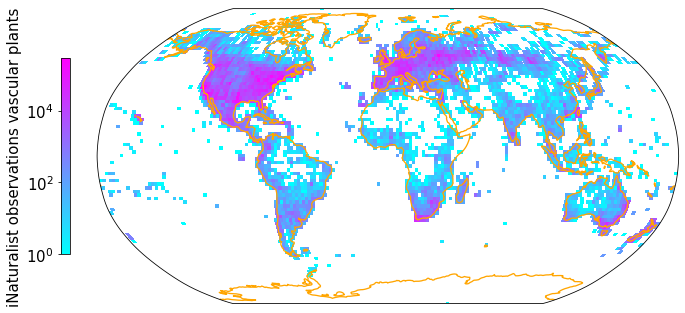

In [41]:
plt.rcParams.update({'font.size': 15})

Z, xedges, yedges = np.histogram2d(np.array(iNat_TRY['decimalLongitude'],dtype=float),
                                   np.array(iNat_TRY['decimalLatitude']),bins = [181, 91])

data_crs = ccrs.PlateCarree()
#for colorbar
cmap = plt.get_cmap('cool')
im_ratio = Z.shape[0]/Z.shape[1]

#plot map
fig = plt.figure(figsize=(12, 12)) # I created a new figure and set up its size

#create base plot of a world map
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson()) # I used the PlateCarree projection from cartopy
ax.set_global()
#add coastlines
ax.coastlines(resolution='110m', color='orange', linewidth=1.3)
#add grid with values
im = ax.pcolormesh(xedges, yedges, Z.T, cmap="cool", norm=LogNorm(), transform=data_crs)
#add color bar
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad=0.05)
#fig.colorbar(im, cax=cax)
fig.colorbar(im,fraction=0.046*im_ratio, pad=0.04, shrink=0.3, location="left", label="iNaturalist observations vascular plants")


plt.savefig('Figures/iNat_density_Robinson_TRY.pdf', bbox_inches='tight')

